# Imports

In [ ]:
import re
import random
import os, subprocess
from tqdm import tqdm
from copy import deepcopy
from typing import Optional, Tuple, List

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST

from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

from diffusion import DDPM, ForwardDiffusion, ReverseDiffusion, get_beta_schedule
from unet import LabeledDataset, get_labeled_data_loader, MyUNet
from smallnet import LinearNet, Net, split_dataset


MODELS_DIR = "models"
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
SAVE_DPPM_MNIST_PATH = f"{MODELS_DIR}/ddpm_mnist.pt"

# Downloads

In [ ]:
!pip install -U gdown
!pip install umap-learn

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=57f2daefffde77dc03309be6d2bb1e3d403278b8f9486d726030f9b083433483
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
# Downloading pretrained model
!gdown -O "models/ddpm_mnist.pt" "https://drive.google.com/uc?id=1fSPB08M6aBNmhjRgSn3qpdq5hXl1Xhao"

Downloading...
From: https://drive.google.com/uc?id=1fSPB08M6aBNmhjRgSn3qpdq5hXl1Xhao
To: /content/models/ddpm_mnist.pt
100% 5.26M/5.26M [00:00<00:00, 38.0MB/s]


## MNIST Dataset

In [ ]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2*x - 1)  # Normalize MNIST data
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices, test_indices = split_dataset(train_dataset, num_train_per_class=32, num_test_per_class=64)

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 115100262.85it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103358100.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50148951.08it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5563822.65it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Denoising Diffusion Probabilistic Model (DDPM)

In [ ]:
def train_DDPM(ddpm: DDPM, dataloader: DataLoader, lr: float, weight_decay: float, n_iters: int, device: str = "cpu", log_every: int = 500):
    ddpm = ddpm.to(device)
    optimizer = th.optim.AdamW(ddpm.model.parameters(), lr=lr, weight_decay=weight_decay)
    step = 0
    curr_loss_gauss = 0.0
    curr_count = 0
    optimizer.zero_grad()
    data_iter = iter(dataloader)
    while step < n_iters:
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            batch = next(data_iter)
        x, y = batch["x"].to(device), batch["y"].to(device)

        loss = ddpm.train_loss(x, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        curr_count += len(x)
        curr_loss_gauss += loss.item() * len(x)

        if (step + 1) % log_every == 0:
            gloss = np.around(curr_loss_gauss / curr_count, 4)
            print(f"Step {(step + 1)}/{n_iters} Loss: {gloss}")
            curr_count = 0
            curr_loss_gauss = 0.0
        step += 1

In [ ]:
T = 1000
BATCH_SIZE = 1024
LR = 0.01
WEIGHT_DECAY = 0.0
N_ITERS = 5000

device = th.device("cuda" if th.cuda.is_available() else "cpu")

model_dif = MyUNet()

if not os.path.exists(SAVE_DPPM_MNIST_PATH):
    print("Pretrained model does not exist, start training")
    th.manual_seed(0)
    random.seed(0)
    ddpm = DDPM(betas=get_beta_schedule(T), model=model_dif, clip_x0=True)
    dataloader = get_labeled_data_loader(train_dataset, test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_DDPM(ddpm=ddpm, dataloader=dataloader, lr=LR, weight_decay=WEIGHT_DECAY, n_iters=N_ITERS, device=device)
    th.save(ddpm.to("cpu").state_dict(), SAVE_DPPM_MNIST_PATH)
else:
    print("Loaded a pretrained model")
    ddpm = DDPM.from_pretrained(model_dif, SAVE_DPPM_MNIST_PATH)

_ = ddpm.to(device)

Loaded a pretrained model


/content/diffusion.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("clip_x0", th.tensor(clip_x0, dtype=bool))


# Training Simple Neural Net

In [ ]:
def train_model(train_loader, t_up, batch_size, model, criterion, optimizer, model_dif, forward_diffusion, epochs=90, loss_list=[]):
    model.train()
    loss_list = []
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            features = extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion)
            outputs = model(features)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    th.save({'model_state_dict': model.state_dict()}, f'/content/{folder}/{t_up}-Lin.pth')
    return loss_list


def extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion):
    """
    Extracts features, namely concatenates averaged arrays from different layers of the diffusion model with the UNet architecture.
    :t_up: from which step of the forward diffusion process image is needed.
    :model_dif: a diffusion model.
    :forward_diffusion: forward diffusion process.
    :return: a tensor of shape [batch_size, 80].
    """
    with torch.no_grad():
        Xs = forward_diffusion.q_sample(x0=images, t=(th.ones(images.shape[0], device=images.device) * (t_up)).long()).to(device)
        t = th.tensor([t_up] * batch_size).to(device)
        features = model_dif.get_features(x=Xs, t=t, y=labels)
    return features


def test_model(model, test_loader, t_up, batch_size, forward_diffusion, model_dif=model_dif):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")
    return accuracy

In [ ]:
input_size = 80
num_classes = 10
epochs = 90
T = 1000
forward_diffusion = ForwardDiffusion(betas=get_beta_schedule(T))
t_up = 50

folder = 'smallclassifier'
if not os.path.exists(folder):
    os.mkdir(folder)

PATH = f"/content/{folder}/{t_up}-NonLin.pth"

model = Net(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_list = train_model(train_loader, t_up, batch_size, model, criterion, optimizer, model_dif, forward_diffusion, epochs=epochs)
accuracy = test_model(model, test_loader, t_up, batch_size, forward_diffusion, model_dif=model_dif)
accuracy

Epoch 1, Loss: 2.2508874416351317
Epoch 2, Loss: 2.079162263870239
Epoch 3, Loss: 1.9241861343383788
Epoch 4, Loss: 1.7678539633750916
Epoch 5, Loss: 1.6146695375442506
Epoch 6, Loss: 1.4702274680137635
Epoch 7, Loss: 1.3411085486412049
Epoch 8, Loss: 1.2206283450126647
Epoch 9, Loss: 1.1147313833236694
Epoch 10, Loss: 1.0166365563869477
Epoch 11, Loss: 0.9361763656139374
Epoch 12, Loss: 0.8520334720611572
Epoch 13, Loss: 0.7814200222492218
Epoch 14, Loss: 0.7209463715553284
Epoch 15, Loss: 0.6657830595970153
Epoch 16, Loss: 0.6142387151718139
Epoch 17, Loss: 0.5699122846126556
Epoch 18, Loss: 0.5288948625326156
Epoch 19, Loss: 0.49572293758392333
Epoch 20, Loss: 0.47120826244354247
Epoch 21, Loss: 0.44089282751083375
Epoch 22, Loss: 0.40979930460453035
Epoch 23, Loss: 0.38789152503013613
Epoch 24, Loss: 0.3682177037000656
Epoch 25, Loss: 0.3523178681731224
Epoch 26, Loss: 0.33158948123455045
Epoch 27, Loss: 0.3174885481595993
Epoch 28, Loss: 0.3063891217112541
Epoch 29, Loss: 0.288868

94.0625

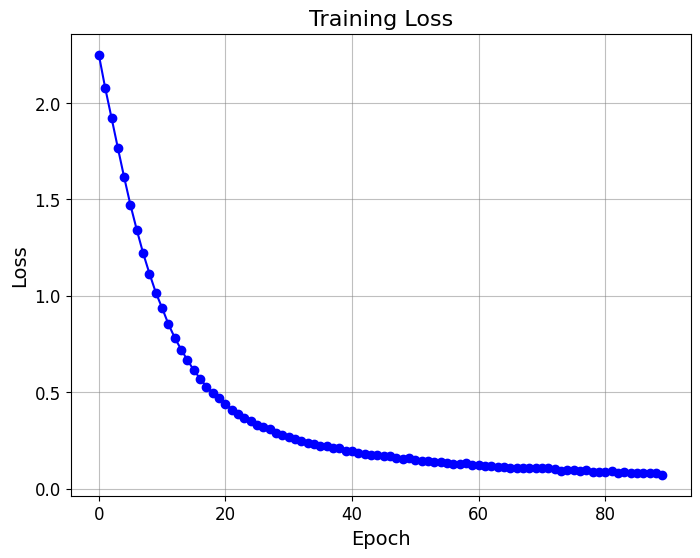

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(loss_list, marker='o', color='blue', linestyle='-')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss', fontsize=16)
plt.grid(True, color='gray', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Optimal timestep selection

### Linear Model

In [ ]:
random.seed(42)

folder = 'linearnet'
if not os.path.exists(folder):
    os.mkdir(folder)

PATH = f"/content/{folder}/ML/50-Lin.pth"

input_size = 80
num_classes = 10  # Number of classes in MNIST
epochs = 90
batch_size = 32
T = 1000
forward_diffusion = ForwardDiffusion(betas=get_beta_schedule(T))

t_ups = [3, 5, 10, 15, 20, 25, 30, 50, 100, 250, 500, 600, 700, 800, 900, 950, 990, 999]
scores = []


for t_up in t_ups:
    print(f'\nStep: {t_up}')

    model = LinearNet(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(train_loader, t_up, batch_size, model, criterion, optimizer, model_dif, forward_diffusion, epochs=epochs)
    accuracy = test_model(model, test_loader, t_up, batch_size, forward_diffusion, model_dif=model_dif)
    scores.append(accuracy)


Step: 3
Epoch 1, Loss: 2.227469038963318
Epoch 2, Loss: 2.1390523672103883
Epoch 3, Loss: 2.073841905593872
Epoch 4, Loss: 2.0169116616249085
Epoch 5, Loss: 1.9719980478286743
Epoch 6, Loss: 1.9233151435852052
Epoch 7, Loss: 1.8812386035919189
Epoch 8, Loss: 1.8391517877578736
Epoch 9, Loss: 1.8010173797607423
Epoch 10, Loss: 1.7635717511177063
Epoch 11, Loss: 1.7246358394622803
Epoch 12, Loss: 1.6900994062423706
Epoch 13, Loss: 1.6559011578559875
Epoch 14, Loss: 1.6229843378067017
Epoch 15, Loss: 1.5917137742042542
Epoch 16, Loss: 1.560654103755951
Epoch 17, Loss: 1.5314377069473266
Epoch 18, Loss: 1.5042925000190734
Epoch 19, Loss: 1.476967740058899
Epoch 20, Loss: 1.4493794918060303
Epoch 21, Loss: 1.4232441782951355
Epoch 22, Loss: 1.3985557913780213
Epoch 23, Loss: 1.3743463158607483
Epoch 24, Loss: 1.3509436011314393
Epoch 25, Loss: 1.3288220643997193
Epoch 26, Loss: 1.3060160875320435
Epoch 27, Loss: 1.2850999593734742
Epoch 28, Loss: 1.2647534489631653
Epoch 29, Loss: 1.245234

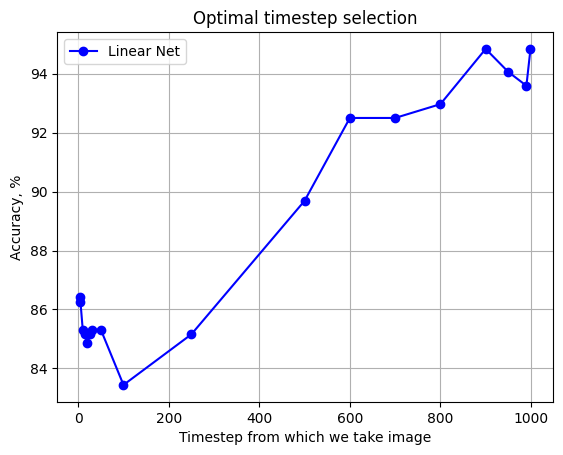

In [ ]:
plt.plot(t_ups, scores, marker='o', color='blue', label='Linear Net')
plt.xlabel('Timestep from which we take image')
plt.ylabel('Accuracy, %')
plt.title('Optimal timestep selection')
plt.grid(True)
plt.legend()
plt.show()

## UMAP decomposition, how good classes are divided

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

### Original MNIST

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


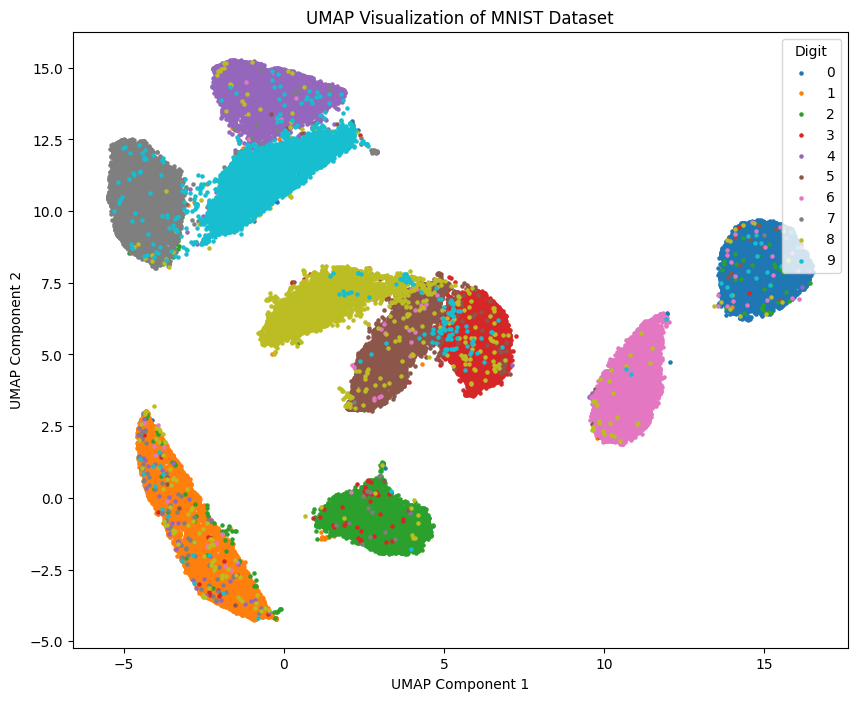

In [ ]:
X = train_dataset.data.cpu().detach().numpy().reshape(train_dataset.data.shape[0], -1)
y = train_dataset.targets.cpu().detach().numpy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], label=str(i), s=5)
plt.title('UMAP Visualization of MNIST Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Digit', loc='upper right')
plt.show()

### MNIST with Extracted Features, **t_up=999**

In [ ]:
def extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion):
    """
    Extracts features, namely concatenates averaged arrays from different layers of the diffusion model with the UNet architecture.
    :t_up: from which step of the forward diffusion process image is needed.
    :model_dif: a diffusion model.
    :forward_diffusion: forward diffusion process.
    :return: a tensor of shape [batch_size, 80].
    """
    with torch.no_grad():
        Xs = forward_diffusion.q_sample(x0=images, t=(th.ones(images.shape[0], device=images.device) * (t_up)).long()).to(device)
        t = th.tensor([t_up] * batch_size).to(device)
        features = model_dif.get_features(x=Xs, t=t, y=labels)
    return features


t_up, batch_size = 999, 1
features_999 = []
for images, labels in train_dataset:
    images, labels = images.to(device), torch.tensor(labels).to(device)
    feature = extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion)
    features_999.append(feature.cpu().detach().numpy().flatten())

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features_999)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


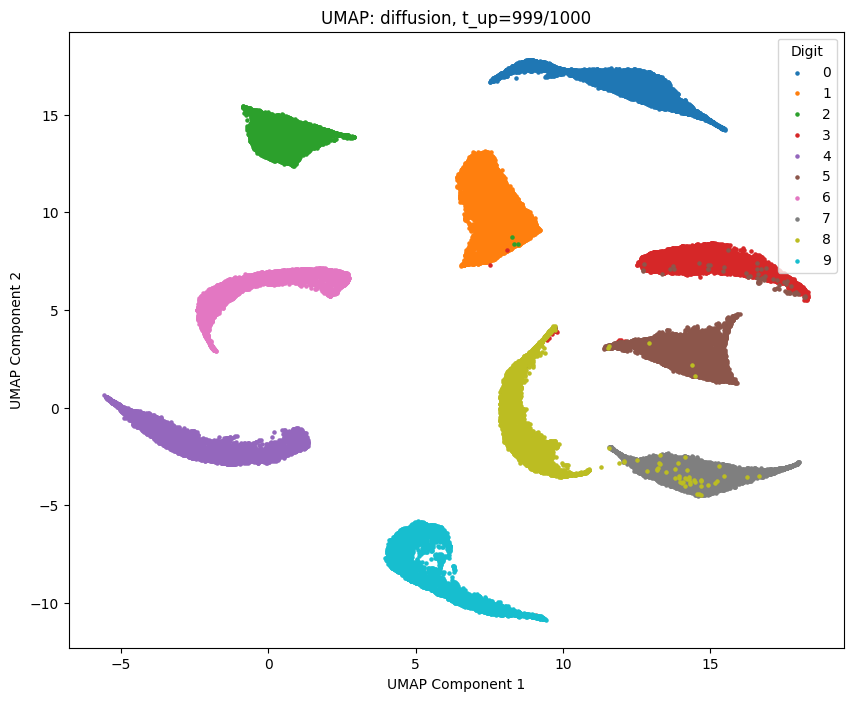

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], label=str(i), s=5)
plt.title('UMAP: diffusion, t_up=999/1000')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Digit', loc='upper right')
plt.show()

### **t_up=999**, code with images

In [ ]:
from matplotlib import offsetbox
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_embedding(X, y, images_small=None, title=None):
    """
    Nice plot on first two components of embedding with Offsets.

    """
    # take only first two columns
    X = X[:, :2]
    # scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(13,8))
    ax = plt.subplot(111)

    for i in range(X.shape[0] - 1):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.RdGy(y[i]),
                 fontdict={'weight': 'bold', 'size': 12})
        if images_small is not None:
            imagebox = OffsetImage(images_small[i], zoom=.4, cmap = 'gray')
            ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                xycoords='data')
            ax.add_artist(ab)

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-1:
                # don't show points that are too close
                continue
    if title is not None:
        plt.title(title)

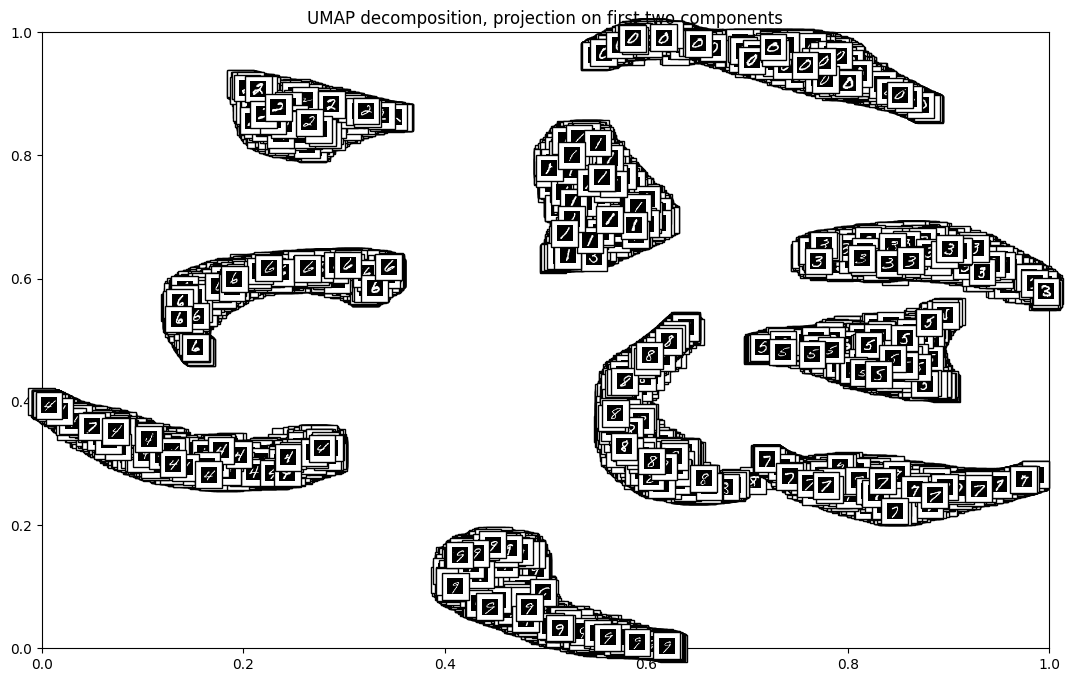

In [ ]:
data_pic = X.reshape((-1, 28, 28))
plot_embedding(X_umap, y, data_pic, "UMAP decomposition, projection on first two components")

### **t_up = 0**

In [ ]:
t_up, batch_size = 0, 1
features_0 = []
for images, labels in train_dataset:
    images, labels = images.to(device), torch.tensor(labels).to(device)
    feature = extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion)
    features_0.append(feature.cpu().detach().numpy().flatten())

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features_0)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


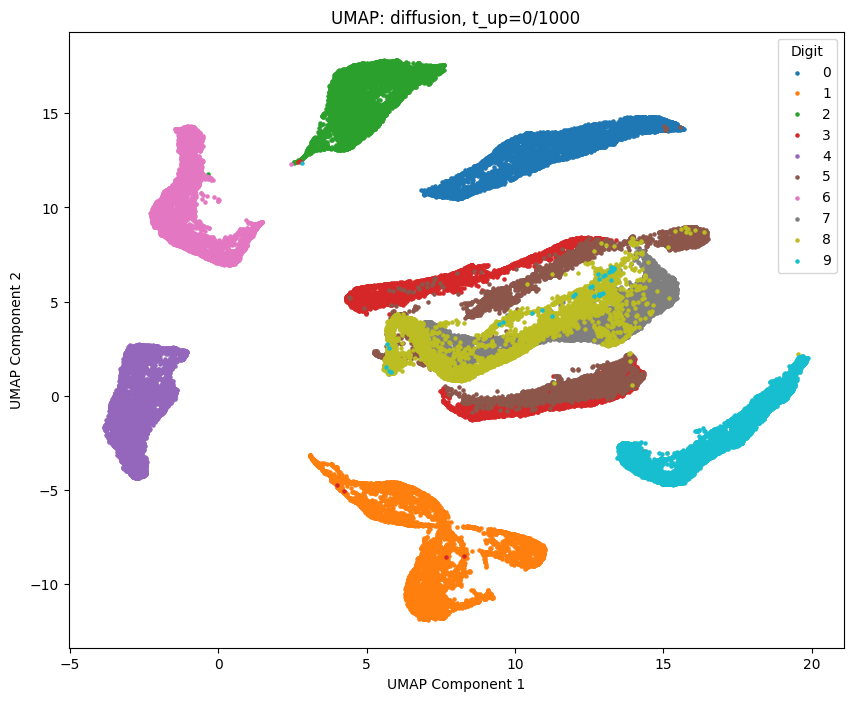

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], label=str(i), s=5)
plt.title('UMAP: diffusion, t_up=0/1000')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Digit', loc='upper right')
plt.show()

### **t_up=200**

In [ ]:
t_up, batch_size = 200, 1
features_200 = []
for images, labels in train_dataset:
    images, labels = images.to(device), torch.tensor(labels).to(device)
    feature = extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion)
    features_200.append(feature.cpu().detach().numpy().flatten())

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features_200)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


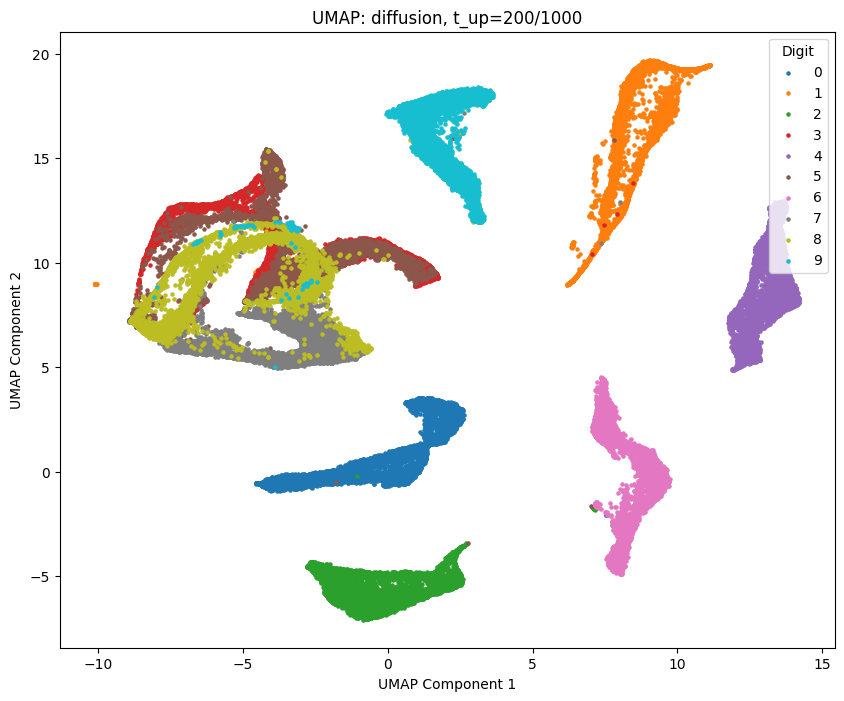

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], label=str(i), s=5)
plt.title('UMAP: diffusion, t_up=200/1000')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Digit', loc='upper right')
plt.show()